## Кривоногов Н.В., Глубокое обучение в компьютерном зрении. Интерактивный курс, практическое задание № 8

###Реализовать синтезирование лиц из LFW с помощью DCGAN

Библиотеки: [Python, Tensorflow]

Спасибо Алексею за помощь в понимании кода.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [18]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info = True
)

In [19]:
len(train_ds), len(test_ds)

(10586, 2647)

## Визуализация датасета LFW

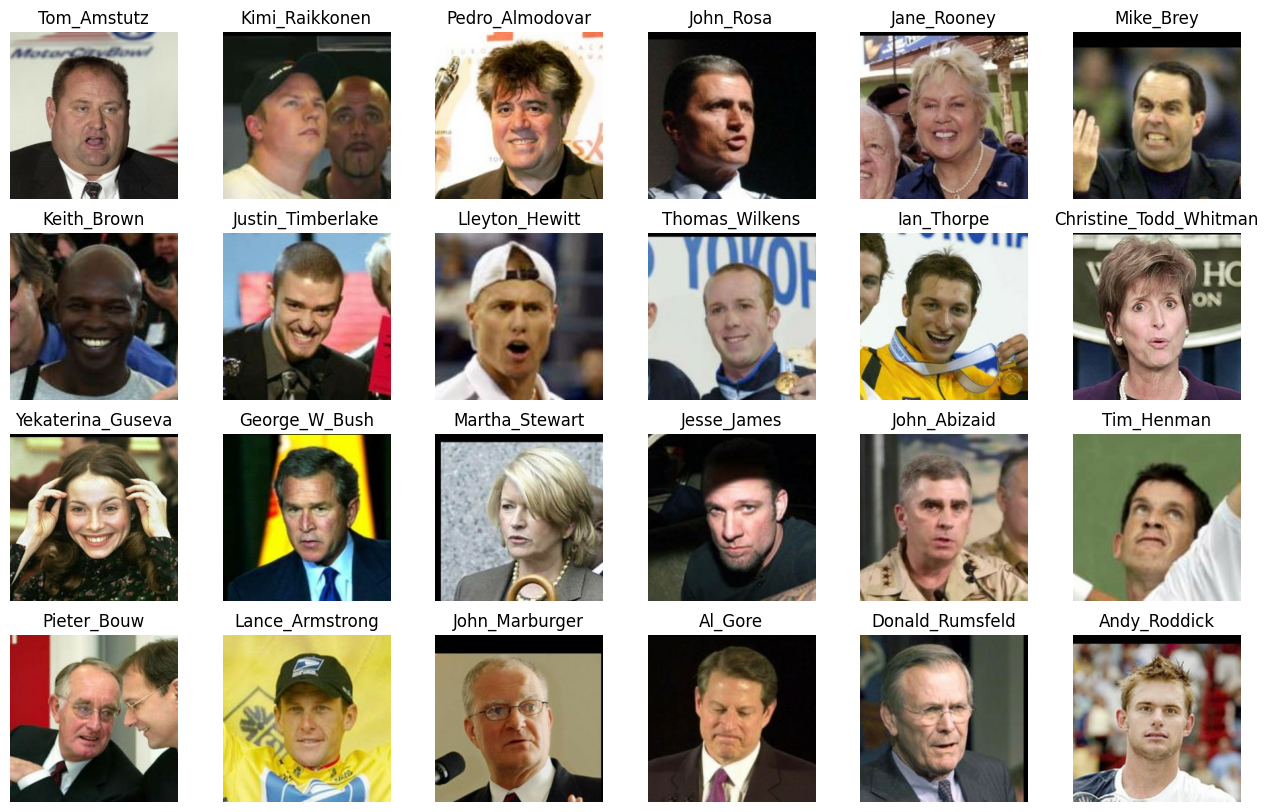

In [20]:
plt.figure(figsize=(16, 10))
for i, data in enumerate(train_ds.take(24)):
    plt.subplot(4, 6, i + 1)
    plt.title(data[0].numpy().decode('utf-8'))
    plt.imshow(data[1])
    plt.axis('off')

In [21]:
def plot_faces(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        new_img = (samples[j, ...] * 127.5) + 127.5
        new_img = (tf.cast(new_img, tf.int16))
        ax.imshow(new_img)
        plt.xticks([]), plt.yticks([])
    plt.show()

In [22]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*7*7),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh')
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

In [23]:
NUM_EPOCHS = 5
HALF_BATCH_SIZE = 16  # размер серии генерируемых картинок

def prepare_img(label, img):
    img = tf.image.resize(img, [224, 224]) # корректировка размерности входа в модель
    return label, (tf.cast(img, tf.float32) - 127.5) / 127.5  # стандартизация картинок от -1 до 1

train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(prepare_img)

In [24]:
INPUT_DIM = 200
BATCH_SIZE = HALF_BATCH_SIZE * 2  # вторая половина батча - истинные картинки
LEARNING_RATE = 0.0008

optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8697; G Loss: 0.2150
1/1 [==============================] - 0s 395ms/step


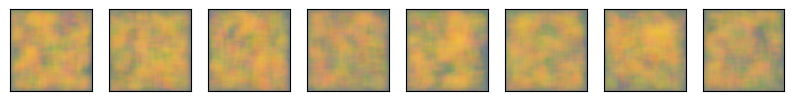

[Step 1000] D Loss: 9.0863; G Loss: 30.2071
1/1 [==============================] - 0s 41ms/step


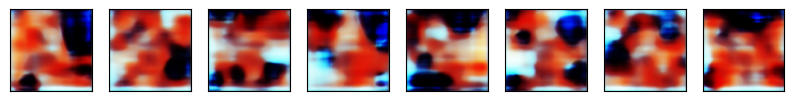

[Step 2000] D Loss: 0.9369; G Loss: 19.1111
1/1 [==============================] - 0s 20ms/step


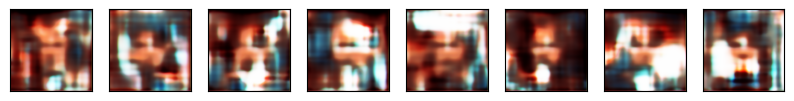

[Step 3000] D Loss: 2.0555; G Loss: 6.9906
1/1 [==============================] - 0s 25ms/step


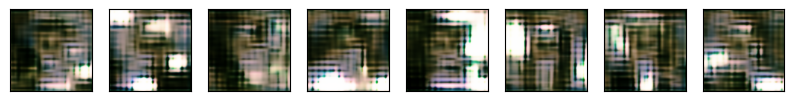

CPU times: user 11min 55s, sys: 33.5 s, total: 12min 28s
Wall time: 16min 53s


In [25]:
%%time
tf.get_logger().setLevel('ERROR')

for step, (_, true_images) in enumerate(train_ds):

    # Train Discriminator (шаг обучения генератора)

    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise, verbose=0)  # получаем батч синтетических картинок
    x_combined = np.concatenate((
        true_images,
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32),   # единицы соответствуют истинным картинкам
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))  # нули соответствуют синтетическим картинкам

    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train Generator (шаг обучения генератора)

    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)  # генерируем батч случайных векторов
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)  # сощдаем метки 1 для дискриминатора

    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)  # при training=True BatchNormalization работает в режиме обучения
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Check intermediate results

    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)

## Тестирование свёрточного генератора

1/1 [==============================] - 0s 20ms/step


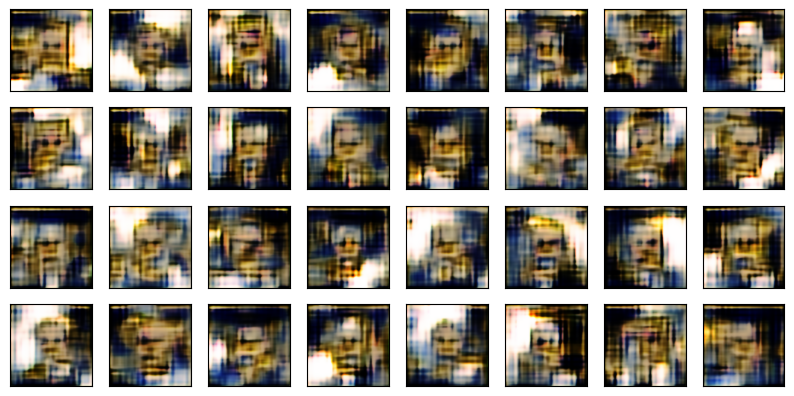

In [26]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

## Интерполяция в латентном пространстве

2/2 [==============================] - 0s 39ms/step


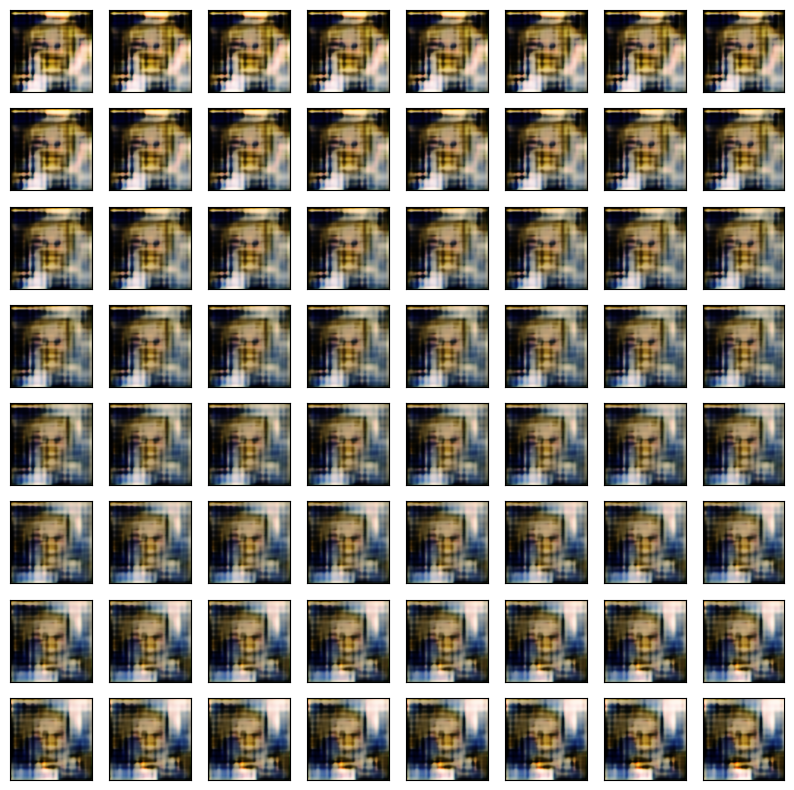

In [27]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 64)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images)

Очень интересные результаты.